In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
%matplotlib inline

In [6]:
df = pd.read_csv("marketing_campaign.csv", sep="\t")
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [10]:
df_new = df.copy()
df_new["Age"] = 2014 - df_new["Year_Birth"]

# заполняем пропуски по Income
df_new["Income"] = df_new["Income"].fillna(df_new["Income"].median())

# оставляем адекватный возраст
df_new = df_new[(df_new["Age"] >= 18) & (df_new["Age"] <= 100)]

# удаляем константные признаки и ID
df_new.drop(["Z_CostContact", "Z_Revenue", "ID"], axis=1, inplace=True)

# обработка даты регистрации
df_new["Dt_Customer"] = pd.to_datetime(df_new["Dt_Customer"], dayfirst=True)
df_new["Customer_For_Days"] = (df_new["Dt_Customer"].max() - df_new["Dt_Customer"]).dt.days

# удаляем исходную дату и год рождения
df_new.drop(["Dt_Customer", "Year_Birth"], axis=1, inplace=True)

df_new.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Customer_For_Days
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,7,0,0,0,0,0,0,1,57,663
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,5,0,0,0,0,0,0,0,60,113
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,4,0,0,0,0,0,0,0,49,312
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,6,0,0,0,0,0,0,0,30,139
4,PhD,Married,58293.0,1,0,94,173,43,118,46,...,5,0,0,0,0,0,0,0,33,161


In [11]:
df_model = pd.get_dummies(                 #преобразование в числовой формат
    df_new,
    columns=["Education", "Marital_Status"],
    drop_first=True
)
df_model.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,58138.0,0,0,58,635,88,546,172,88,88,...,True,False,False,False,False,False,True,False,False,False
1,46344.0,1,1,38,11,1,6,2,1,6,...,True,False,False,False,False,False,True,False,False,False
2,71613.0,0,0,26,426,49,127,111,21,42,...,True,False,False,False,False,False,False,True,False,False
3,26646.0,1,0,26,11,4,20,10,3,5,...,True,False,False,False,False,False,False,True,False,False
4,58293.0,1,0,94,173,43,118,46,27,15,...,False,False,True,False,False,True,False,False,False,False


# 1. Выбор атрибута
В качестве целевого класса был выбран атрибут Has_Kids, отражающий наличие у клиента детей. Данный признак является категориальным и принимает бинарные значения, что позволяет сформулировать задачу бинарной классификации.

In [12]:
df_model["Has_Kids"] = (df_model["Kidhome"] >= 1).astype(int)

# удаляем исходный Kidhome
df_model.drop(["Kidhome"], axis=1, inplace=True)

# проверим баланс
print("Распределение классов Has_Kids:")
print(df_model["Has_Kids"].value_counts(normalize=True) * 100)

Распределение классов Has_Kids:
Has_Kids
0    57.71122
1    42.28878
Name: proportion, dtype: float64


# 2. Оценка сбалансированности классов

Анализ распределения целевого признака Has_Kids показал, что классы представлены в сопоставимых долях: около 58% объектов относятся к классу без детей и около 42% - к классу с детьми. Такое распределение не является критически несбалансированным.

# 3. Оценка и сравнение результатов классификации

In [15]:
y = df_model["Has_Kids"]
X = df_model.drop("Has_Kids", axis=1)

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X.values, y.values,
    test_size=0.3,
    random_state=17,
    stratify=y
)

X_train.shape, X_holdout.shape

((1565, 34), (672, 34))

В результате разбиения данных обучающая выборка содержит 1565 наблюдений, а отложенная выборка - 672 наблюдения при том же количестве признаков.

## Оценка качества базовых моделей классификации

In [20]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

tree_pred_base = tree.predict(X_holdout)
knn_pred_base = knn.predict(X_holdout)

In [22]:
def print_metrics(name, y_true, y_pred):
    print("\n", name, "\n")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

print_metrics("Decision Tree (baseline)", y_holdout, tree_pred_base)
print_metrics("kNN (baseline)", y_holdout, knn_pred_base)


 Decision Tree (baseline) 

Accuracy : 0.8452380952380952
Precision: 0.7922077922077922
Recall   : 0.8591549295774648
F1-score : 0.8243243243243243

Confusion matrix:
[[324  64]
 [ 40 244]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       388
           1       0.79      0.86      0.82       284

    accuracy                           0.85       672
   macro avg       0.84      0.85      0.84       672
weighted avg       0.85      0.85      0.85       672


 kNN (baseline) 

Accuracy : 0.7663690476190477
Precision: 0.7228070175438597
Recall   : 0.7253521126760564
F1-score : 0.7240773286467487

Confusion matrix:
[[309  79]
 [ 78 206]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       388
           1       0.72      0.73      0.72       284

    accuracy                           0.77       672
   macro avg       0.76      0.76  

Результаты оценки качества классификации по метрикам Accuracy, Precision, Recall и F1-score показывают, что базовая модель дерева решений превосходит метод kNN по всем рассмотренным показателям. Дерево решений демонстрирует более высокую полноту и F-меру, что свидетельствует о более устойчивом распознавании объектов целевого класса и меньшем количестве ошибок классификации.

Метод kNN показал удовлетворительные результаты, однако уступает дереву решений как по точности, так и по сбалансированности Precision и Recall. Это указывает на более высокую чувствительность kNN к структуре данных и выбранным параметрам модели.

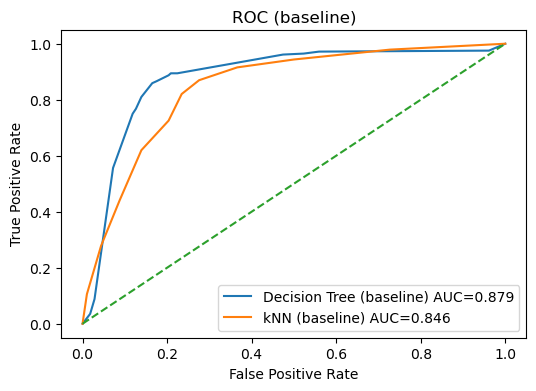

In [28]:
plt.figure(figsize=(6, 4))

for name, model in {
    "Decision Tree (baseline)": tree,
    "kNN (baseline)": knn
}.items():

    proba = model.predict_proba(X_holdout)[:, 1]
    auc = roc_auc_score(y_holdout, proba)
    fpr, tpr, _ = roc_curve(y_holdout, proba)
    plt.plot(fpr, tpr, label=f"{name} AUC={auc:.3f}")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (baseline)")
plt.legend()
plt.show()

Построенные ROC-кривые показывают, что обе базовые модели превосходят случайный классификатор. При этом дерево решений демонстрирует более высокую разделяющую способность по сравнению с методом kNN, что подтверждается большим значением AUC.

## Метод GridSearchCV

In [24]:
tree_base = DecisionTreeClassifier(random_state=17)

tree_params = {
    "max_depth": range(2, 15),
    "max_features": range(4, X_train.shape[1] + 1, 5)
}

tree_grid = GridSearchCV(
    tree_base,
    tree_params,
    cv=5,
    n_jobs=-1,
    verbose=True
)

tree_grid.fit(X_train, y_train)

print("Лучшие параметры дерева:", tree_grid.best_params_)
print("CV accuracy:", tree_grid.best_score_)

tree_best = tree_grid.best_estimator_
tree_pred_tuned = tree_best.predict(X_holdout)


Fitting 5 folds for each of 91 candidates, totalling 455 fits
Лучшие параметры дерева: {'max_depth': 9, 'max_features': 24}
CV accuracy: 0.8645367412140577


In [26]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))
])

knn_params = {"knn__n_neighbors": range(1, 15)}

knn_grid = GridSearchCV(
    knn_pipe,
    knn_params,
    cv=5,
    n_jobs=-1,
    verbose=True
)

knn_grid.fit(X_train, y_train)

print("Лучшие параметры kNN:", knn_grid.best_params_)
print("CV accuracy:", knn_grid.best_score_)

knn_best = knn_grid.best_estimator_
knn_pred_tuned = knn_best.predict(X_holdout)


Fitting 5 folds for each of 14 candidates, totalling 70 fits
Лучшие параметры kNN: {'knn__n_neighbors': 9}
CV accuracy: 0.8185303514376997


## Оценка качества настроенных моделей классификации

In [27]:
print_metrics("Decision Tree (tuned)", y_holdout, tree_pred_tuned)
print_metrics("kNN (tuned)", y_holdout, knn_pred_tuned)


 Decision Tree (tuned) 

Accuracy : 0.8571428571428571
Precision: 0.8309859154929577
Recall   : 0.8309859154929577
F1-score : 0.8309859154929577

Confusion matrix:
[[340  48]
 [ 48 236]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       388
           1       0.83      0.83      0.83       284

    accuracy                           0.86       672
   macro avg       0.85      0.85      0.85       672
weighted avg       0.86      0.86      0.86       672


 kNN (tuned) 

Accuracy : 0.8080357142857143
Precision: 0.7429467084639498
Recall   : 0.8345070422535211
F1-score : 0.7860696517412935

Confusion matrix:
[[306  82]
 [ 47 237]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       388
           1       0.74      0.83      0.79       284

    accuracy                           0.81       672
   macro avg       0.80      0.81      0.

Настройка гиперпараметров привела к улучшению качества обеих моделей по сравнению с базовыми версиями. Дерево решений демонстрирует более сбалансированные значения Precision и Recall и более высокую F-меру, что свидетельствует о более устойчивой работе модели. Метод kNN после настройки показывает рост полноты (Recall), однако по совокупности метрик уступает дереву решений.

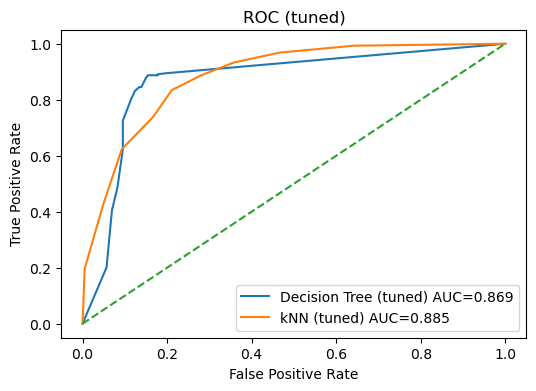

In [30]:
plt.figure(figsize=(6, 4))

for name, model in {
    "Decision Tree (tuned)": tree_best,
    "kNN (tuned)": knn_best
}.items():

    proba = model.predict_proba(X_holdout)[:, 1]
    auc = roc_auc_score(y_holdout, proba)
    fpr, tpr, _ = roc_curve(y_holdout, proba)
    plt.plot(fpr, tpr, label=f"{name} AUC={auc:.3f}")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (tuned)")
plt.legend()
plt.show()

Построенные ROC-кривые для настроенных моделей показывают улучшение разделяющей способности по сравнению с базовыми версиями. После подбора гиперпараметров метод kNN демонстрирует большее значение AUC, однако дерево решений сохраняет более стабильные и сбалансированные показатели качества по совокупности метрик.

In [56]:
rows = [
    ["Decision Tree (baseline)", accuracy_score(y_holdout, tree_pred_base),
     f1_score(y_holdout, tree_pred_base)],
    ["kNN (baseline)", accuracy_score(y_holdout, knn_pred_base),
     f1_score(y_holdout, knn_pred_base)],
    ["Decision Tree (tuned)", accuracy_score(y_holdout, tree_pred_tuned),
     f1_score(y_holdout, tree_pred_tuned)],
    ["kNN (tuned)", accuracy_score(y_holdout, knn_pred_tuned),
     f1_score(y_holdout, knn_pred_tuned)]
]

summary = pd.DataFrame(rows, columns=["Model", "Accuracy", "F1"])
summary

,Model,Accuracy,F1
0,Decision Tree (baseline),0.845238,0.824324
1,kNN (baseline),0.766369,0.724077
2,Decision Tree (tuned),0.857143,0.830986
3,kNN (tuned),0.808036,0.786070


# Вывод
В рамках работы были исследованы и сравнены алгоритмы классификации kNN и дерева решений в базовой и настроенной конфигурациях. Результаты показали, что обе модели улучшают качество классификации после подбора гиперпараметров, что подтверждает эффективность процедуры настройки.

Для метода kNN подбор гиперпараметров с использованием GridSearchCV показал, что оптимальным является значение k = 9. После настройки модель продемонстрировала улучшение показателей качества по сравнению с базовой версией, в частности возросли значения Recall и F1-score. При этом метод kNN остаётся чувствительным к выбору параметра k и структуре данных, что отражается в менее стабильных результатах по сравнению с деревом решений.

Модель дерева решений показала более устойчивое и сбалансированное качество классификации. Подбор гиперпараметров (глубины дерева и числа используемых признаков) позволил повысить Accuracy и F1-score по сравнению с базовой моделью. Дерево решений продемонстрировало лучшие результаты по совокупности метрик, а также более высокую интерпретируемость благодаря явному использованию информативных признаков.

Наилучшие показатели по метрикам Accuracy и F1-score демонстрирует настроенная модель дерева решений. Данный алгоритм показал более устойчивое и сбалансированное качество классификации по сравнению с методом kNN, как в базовой, так и в оптимизированной версии.
Таким образом, для рассматриваемого набора данных и поставленной задачи классификации модель дерева решений является наиболее предпочтительной.